### Imports

In [1]:
import numpy as np
from specmf.models import Graph, MultiFidelityModel
from specmf.utils import error_analysis, load_model_config
from specmf.data import load_data
from specmf.plot import *

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 14px;
</style>

### Data loading

In [3]:
dataset_name = "darcy-flow"

x_LF, x_HF, normalization_vars, mask = load_data(
    dataset_name,
    preprocess=True,
    normalize=True, 
    flatten=True,
    return_mask=True,
    return_normalization_vars=True,
)

print(f"{x_LF.shape=}", f"{x_HF.shape=}")

Loading Darcy flow data ...
x_LF.shape=(5621, 10201) x_HF.shape=(5621, 10201)


### Plot data 

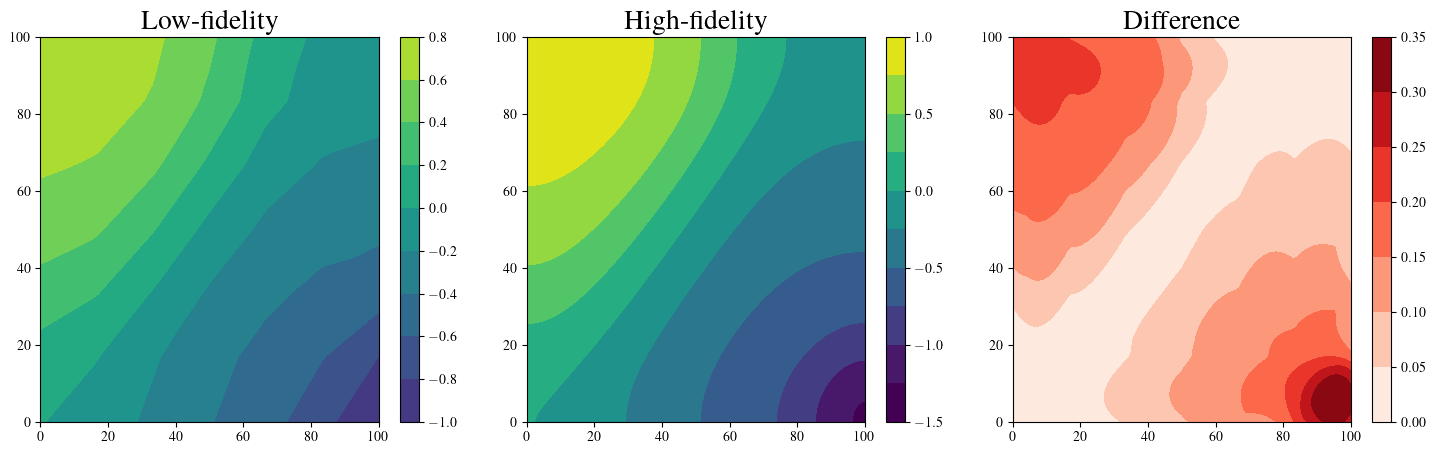

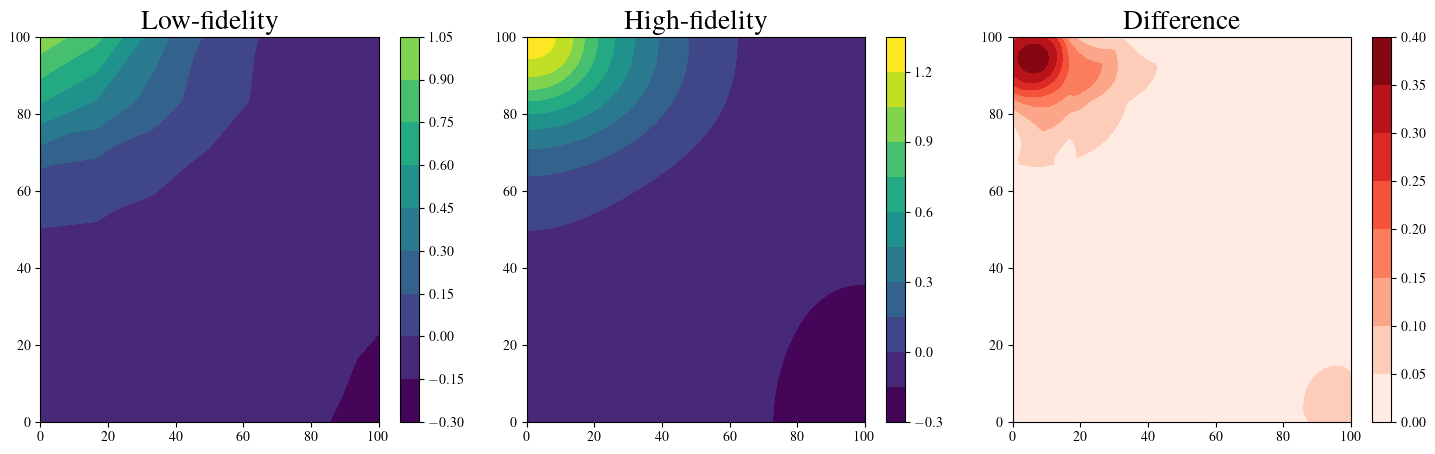

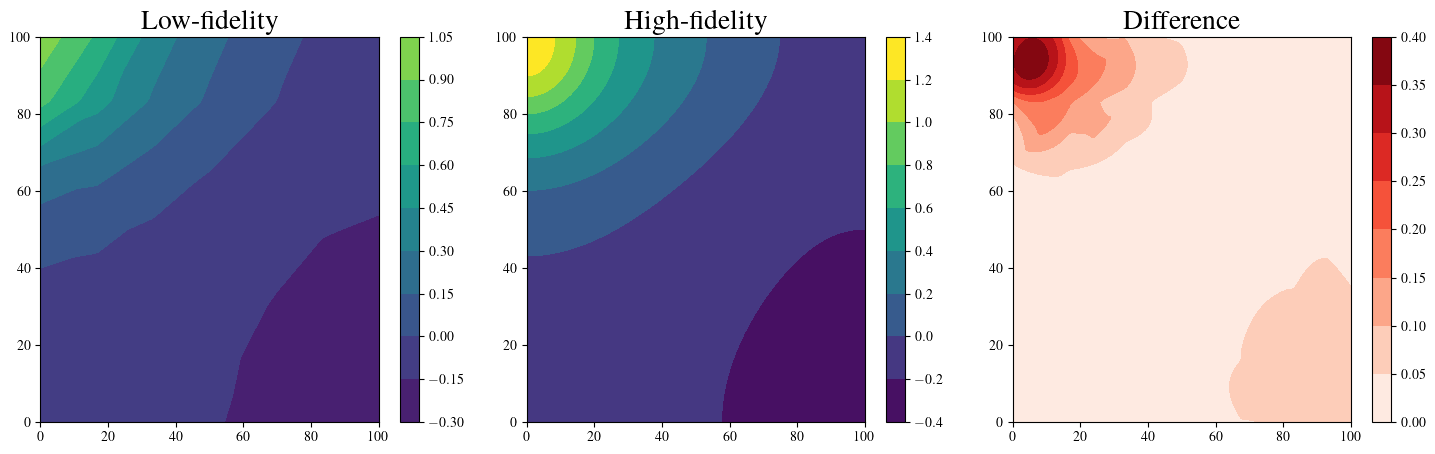

In [4]:
plot_data(x_LF, x_HF, dataset_name, n_samples=3)

### Multi-fidelity model

#### Create graph and model instances

In [5]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'n_components': None,
    'method': 'full',
    'k_nn': None,
    'corr_scale': None,
    'k_adj': 7,
    'p': 0.5,
    'q': 0.5,
}
g_LF = Graph(data=x_LF, **graph_config)

#### Perform spectral clustering

In [6]:
n_HF = 120
inds_train, labels = g_LF.cluster(n_HF)

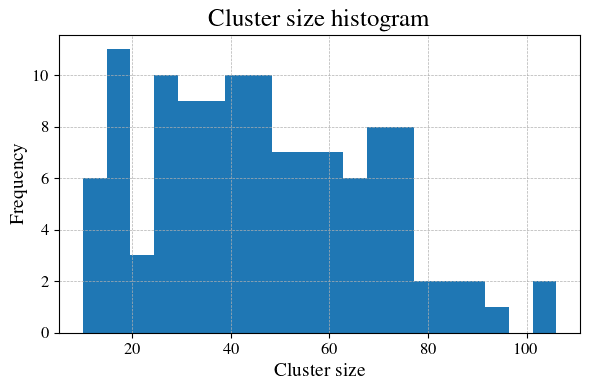

In [7]:
plot_cluster_size_hist(labels)

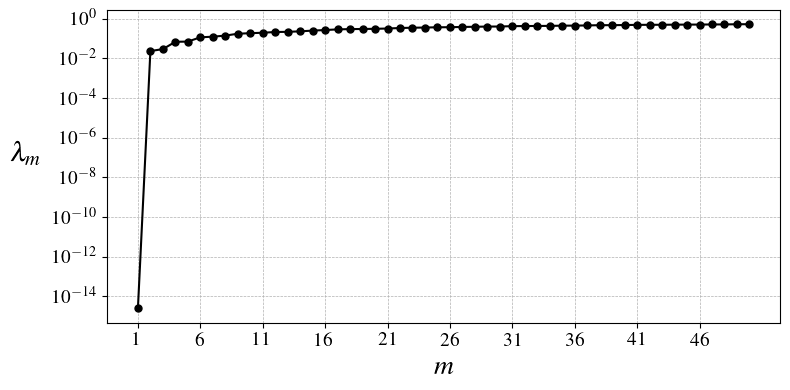

In [8]:
# Plot Laplacian spectrum
eigvals, eigvecs = g_LF.laplacian_eig()
plot_spectrum(eigvals, 50)

#### Split high-fidelity data

In [9]:
n_samples = x_HF.shape[0]
inds_test = np.delete(np.arange(n_samples), inds_train)
x_HF_train = x_HF[inds_train, :]
x_HF_test = x_HF[inds_test, :]

print(f"{x_HF_train.shape=}", f"{x_HF_test.shape=}")

x_HF_train.shape=(120, 10201) x_HF_test.shape=(5501, 10201)


#### Fit and train the model

In [10]:
# Create the model 
model_config = {
    'sigma': 0.01,
    'method': 'trunc',
    'spectrum_cutoff': 1200,
}
model = MultiFidelityModel(**model_config)

fit_model = True

Iteration: 1, Loss: 0.11502968068271986, Gradient: -0.125114930728947, Kappa: 0.0010000000000000002
Iteration: 2, Loss: 0.002261097176613862, Gradient: -0.0036664281019386765, Kappa: 0.022825384416012937
Iteration: 3, Loss: 0.0018857575788360028, Gradient: -0.0031686291337560024, Kappa: 0.025479293718913096
Iteration: 4, Loss: 0.0015508173784078221, Gradient: -0.002713675653945285, Kappa: 0.028557990092915896
Iteration: 5, Loss: 0.0012572539870691934, Gradient: -0.002303779340821668, Kappa: 0.03211000129230118
Iteration: 6, Loss: 0.0010043840107968726, Gradient: -0.001939286879727851, Kappa: 0.0361832197800618
Iteration: 7, Loss: 0.0007902027909750675, Gradient: -0.0016190074864168122, Kappa: 0.04082255011354665
Iteration: 8, Loss: 0.0006117574123800205, Gradient: -0.001340591478887428, Kappa: 0.04606681712904614
Iteration: 9, Loss: 0.00046550339097524234, Gradient: -0.0011009054624792165, Kappa: 0.05194484227029337
Iteration: 10, Loss: 0.0003476126761722708, Gradient: -0.0008963668667

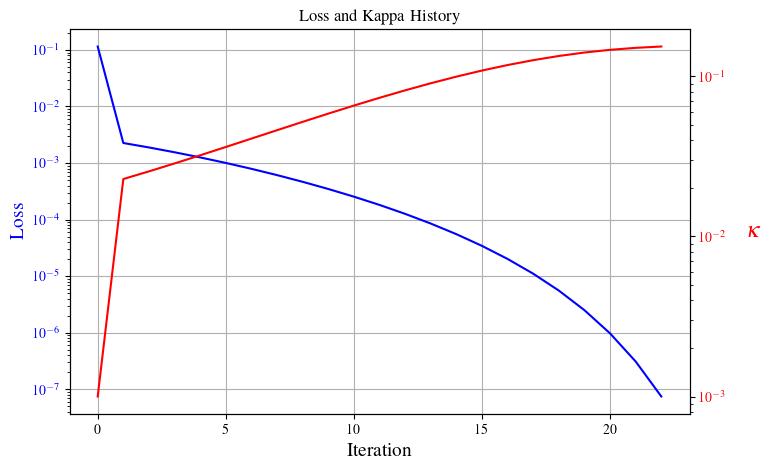

In [11]:
if fit_model:
    model = MultiFidelityModel(**model_config)
    (x_MF, C_phi, dPhi), loss_history, kappa_history = model.fit_transform(
        g_LF,
        x_HF_train,
        inds_train,
        maxiter=30,
        step_size=25,
        step_decay_rate=1.2,
        ftol=1e-7,
        verbose=True,
    )
    model.summary()

    plot_loss_and_kappa(loss_history, kappa_history)

else:
    from pathlib import Path

    notebook_path = Path.cwd()
    yaml_file_path = notebook_path.parent / 'data/model_configs.yaml'
    model_config = load_model_config(yaml_file_path, dataset_name)
    model = MultiFidelityModel(**model_config)
    
    if model_config:
        x_MF, C_phi, dPhi = model.transform(g_LF, x_HF_train, inds_train)
        model.summary()

Text(0.5, 1.0, 'Variance histogram for Darcy problem')

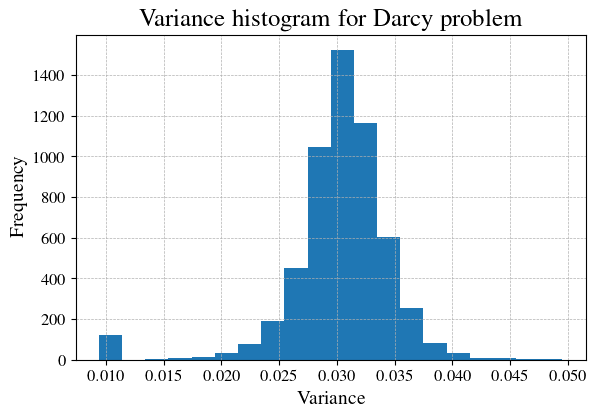

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.hist(dPhi, bins=20)
ax.set_xlabel("Variance", fontsize=14)
ax.set_ylabel("Frequency", fontsize=14)
ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout()
ax.tick_params(axis="both", labelsize=12)
ax.set_title("Variance histogram for Darcy problem", fontsize=18)

### Results

In [13]:
# Error Analysis for unseen test datadet
error_analysis(x_LF[inds_test], x_MF[inds_test], x_HF_test)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         25.2
Error MF:         4.02
Percentage drop:  84.06%


In [14]:
# Error Analysis for the whole dataset
error_analysis(x_LF, x_MF, x_HF)

Mean relative l2 errors and Improvement Factor (IF)
----------------------------------------------------
Error LF:         25.2
Error MF:         3.94
Percentage drop:  84.37%


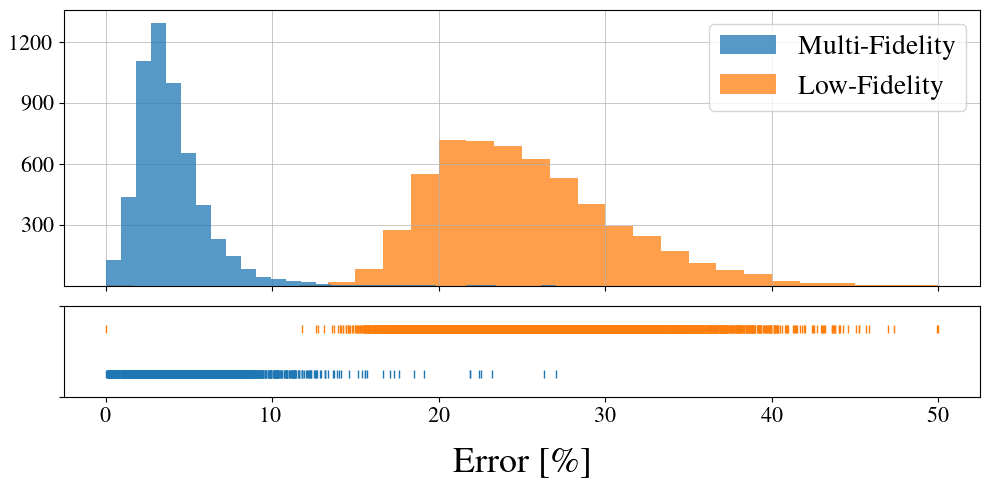

In [15]:
E_LF = 100 * np.linalg.norm(x_LF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)
E_MF = 100 * np.linalg.norm(x_MF - x_HF, axis=1) / (np.mean(np.linalg.norm(x_HF, axis=1)) + 1e-3)

plot_distributions(E_LF, E_MF, bins_LF=30, bins_MF=30, mask=None)

In [16]:
import os
data_path = "/Users/orazio/Desktop/codes/spectral-multifidelity/data/"
K = np.load(os.path.join(data_path, "darcy/K.npy"))
K = K[:, :, mask]

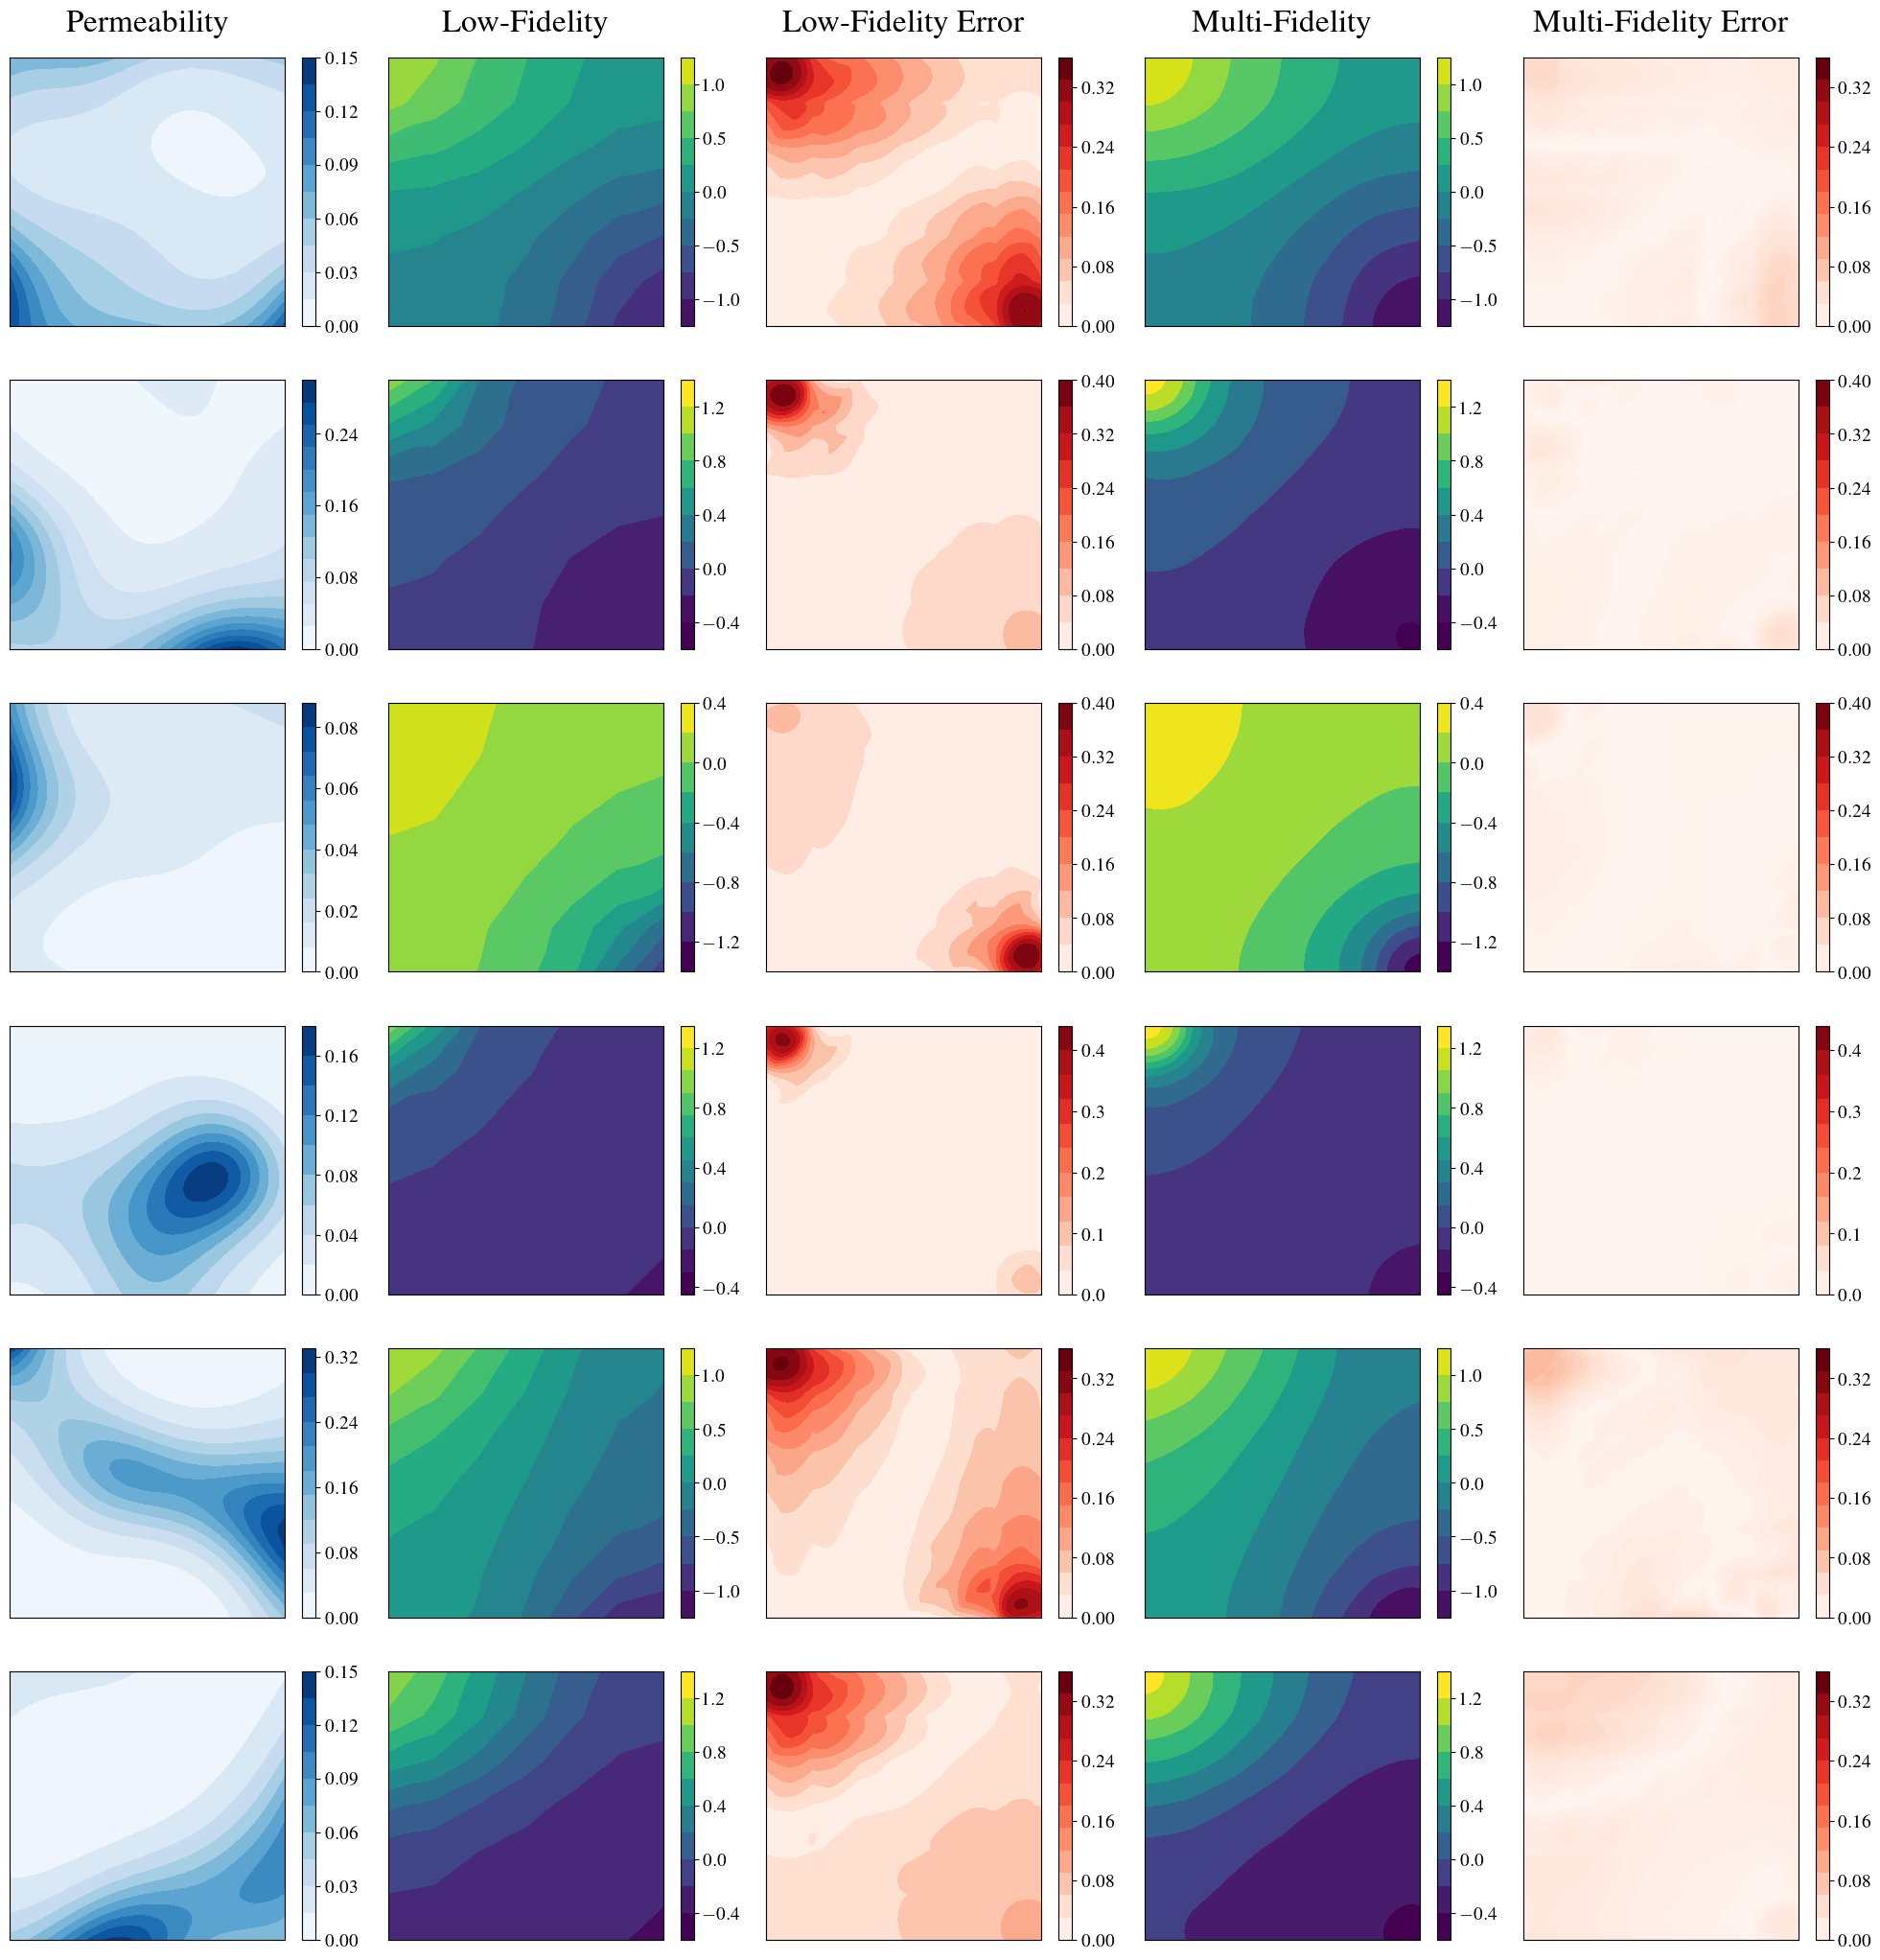

In [17]:
plot_mf_comparison(
    dataset_name=dataset_name,
    X_LF=x_LF,
    X_MF=x_MF,
    X_HF=x_HF,
    samples=[4059, 5505, 1131, 3367, 11, 194],
    input_field=K,
)

### Explore UQ applications

In [18]:
import matplotlib.ticker as ticker

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

In [19]:
g_MF = Graph(data=x_MF, **graph_config)

In [20]:
_, eigevs = g_MF.laplacian_eig()
X = np.real(eigvecs[:, :n_HF])

In [21]:
import umap

X_umap = umap.UMAP(
    n_components=2,
    n_neighbors=20,
    min_dist=0.175,
    init='random', 
    random_state=42
).fit_transform(X)

/opt/homebrew/Caskroom/miniforge/base/envs/generic-env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Text(0.5, 1.0, 'UMAP of Darcy Flow data (Case 3)')

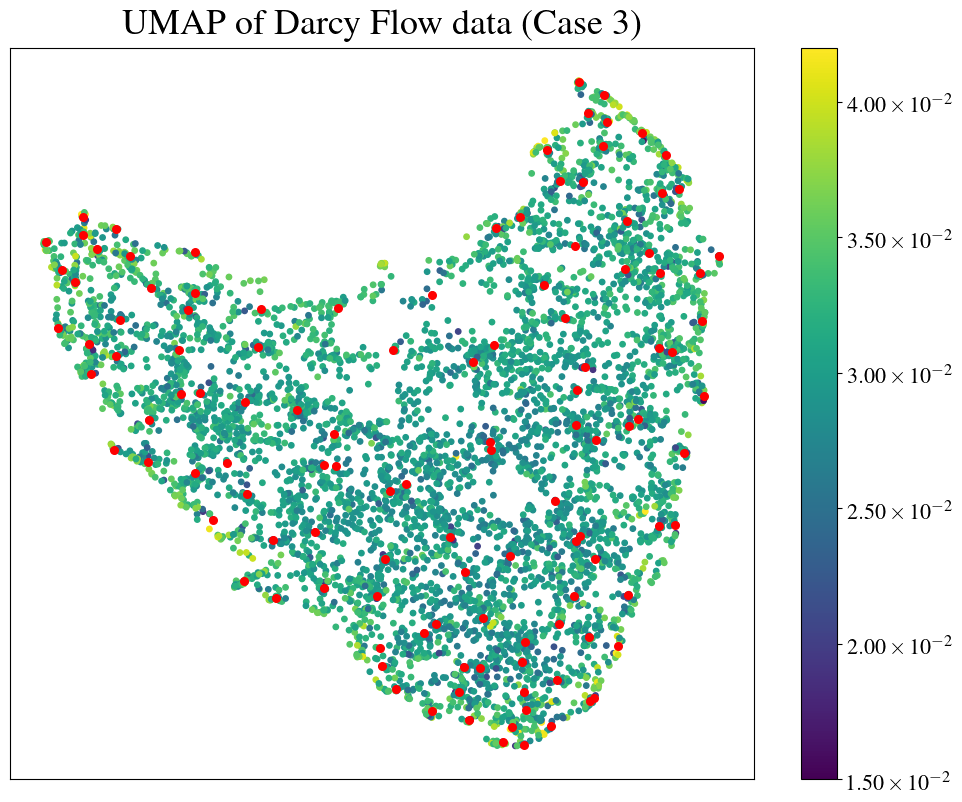

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(12, 9.5))
ax1 = ax.scatter(X_umap[:, 0], X_umap[:, 1], s=15, c=dPhi, vmin=0.015, vmax=0.042)
ax.scatter(X_umap[inds_train, 0], X_umap[inds_train, 1], s=30, c='r', marker='o')
cb = plt.colorbar(ax1, format=ticker.FuncFormatter(fmt))
cb.ax.tick_params(labelsize=16)
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('UMAP of Darcy Flow data (Case 3)', fontsize=26, pad=10)